In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import scipy.stats as stats
import math
import plot_tools as ptools

def Gauss(x, A, mu, sig):
    y = A*np.exp(-(x-mu)**2/(2*sig**2))
    return y


In [3]:
######## USER ##########

balanced = False
max_perclass = 10000

targets = ['SNIa-SALT2', 'SNII+HostXT_V19', 'TDE', 'SNIb+HostXT_V19', 'SLSN-I+host', 'SNIc+HostXT_V19'] #, 'PISN'
rename = ['SNIa', 'SNII', 'TDE', 'SNIb', 'SLSN', 'SNIc'] #, 'PISN'
 
########################

features = [None, None]

for idx, method in enumerate(['bazin', 'mbf']):

    all_features = [None] * len(targets)
    for idx2, t in enumerate(targets):
        all_features[idx2] = pd.read_parquet(f'../data/features/{method}/{t}_features.parquet')
        all_features[idx2]['target'] = rename[idx2]

    if balanced:
        nobj = min([len(x) for x in all_features])
        for idx3 in range(len(all_features)):
            all_features[idx3] = all_features[idx3][:nobj]
            
        features[idx] = pd.concat(all_features)

    else:
        
        for idx3 in range(len(all_features)):
            all_features[idx3] = all_features[idx3][:max_perclass]
            
        features[idx] = pd.concat(all_features)
    
# Remove unwanted columns
features[0].drop(columns={'nb_points_g', 'nb_points_r', 'nb_points_i'}, inplace=True)
features[1].drop(columns={'nb_points'}, inplace=True)
    
methods = [[features[0], 'bazin'], [features[1], 'mbf']]

In [4]:
from collections import Counter
Counter(methods[0][0]['target'])

Counter({'SNIa': 5180,
         'SNII': 1301,
         'TDE': 10000,
         'SNIb': 2506,
         'SLSN': 10000,
         'SNIc': 2651})

# Predict the target

bazin : Accuracy on testing sample is : 90.12%
Efficiency : 96.39% of real SNIa were labeled as SNIa
Purity : 87.11% of classified SNIa were indeed SNIa


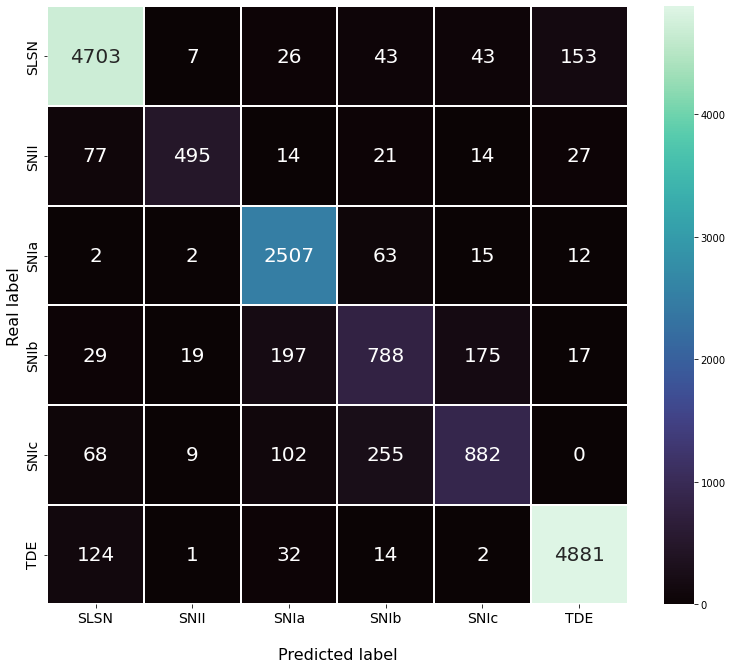

mbf : Accuracy on testing sample is : 91.00%
Efficiency : 95.58% of real SNIa were labeled as SNIa
Purity : 89.36% of classified SNIa were indeed SNIa


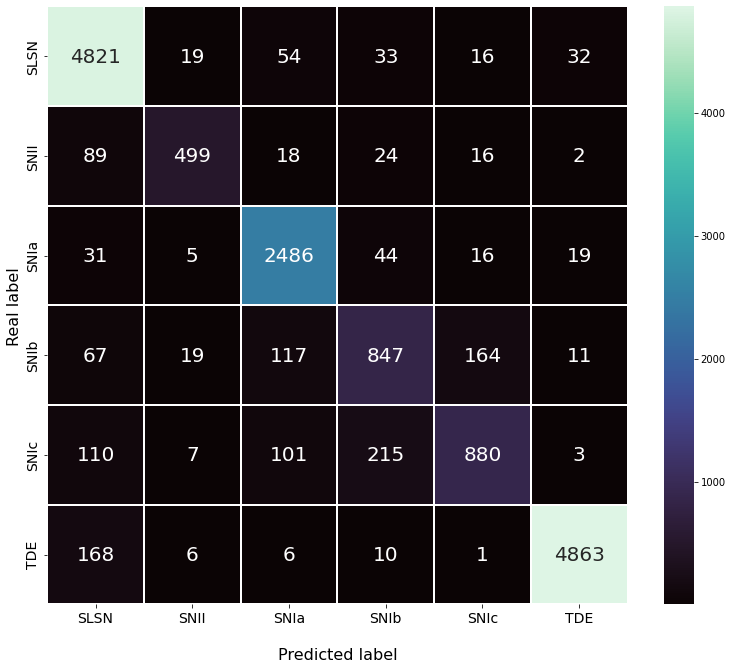

In [5]:
seed = 42

rf = {}

for method in methods:
    
    X_train, X_test, y_train, y_test = train_test_split(method[0].drop(columns={'target', 'true_peak'}), method[0]['target'], test_size=0.5, random_state=seed)
    clf = RandomForestClassifier(n_estimators = 100, random_state=seed)
    clf.fit(X_train, y_train)
    
    rf[method[1]] = clf

    score = clf.score(X_test, y_test)
    print(f'{method[1]} : Accuracy on testing sample is : {score*100:.2f}%')
    ptools.draw_confusion(clf, X_test, y_test, interest=rename[0])

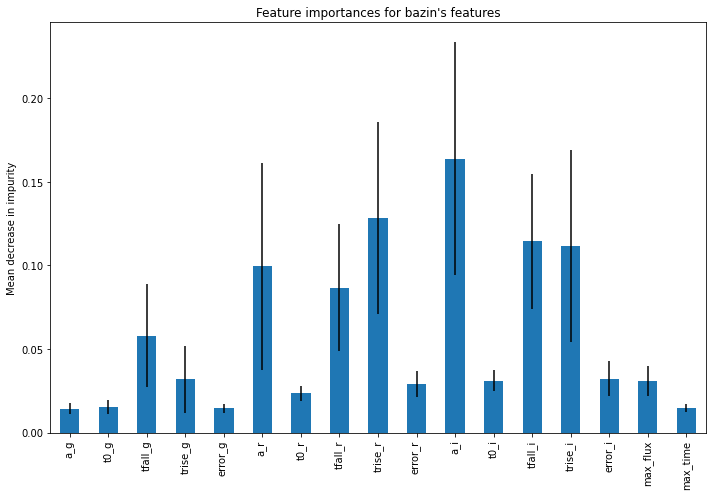

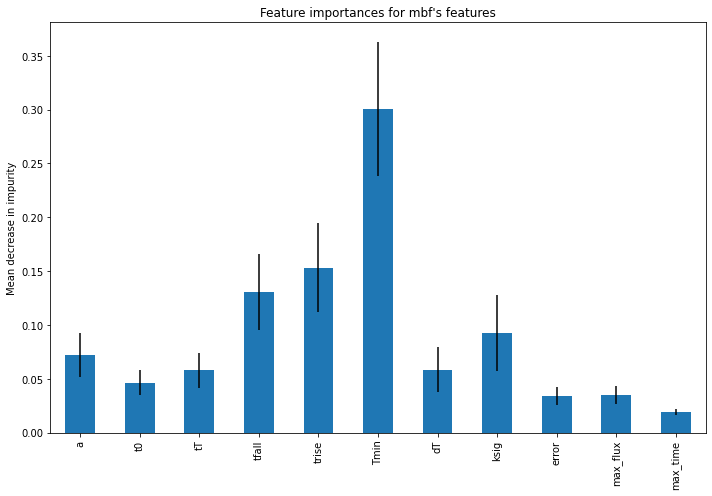

In [6]:
for idx, method in enumerate(methods):
    
    importances = rf[method[1]].feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf[method[1]].estimators_], axis=0)

    forest_importances = pd.Series(importances, index=method[0].drop(columns={'target', 'true_peak'}).keys())
    fig, ax = plt.subplots(figsize = (10, 7))


    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(f"Feature importances for {method[1]}'s features")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

# Predict the max peak using machine learning

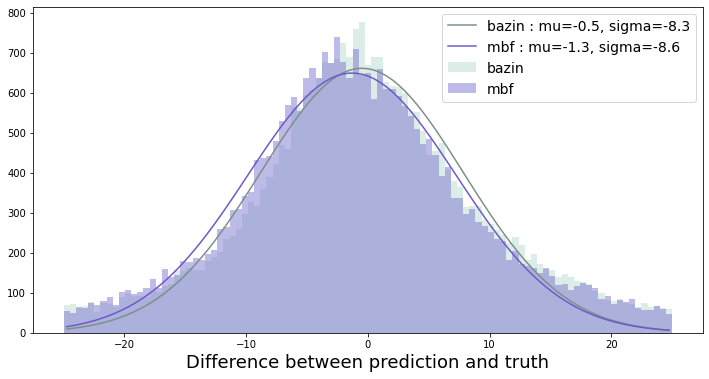

In [7]:
plt.figure(figsize =(12,6))
plt.xlabel("Difference between prediction and truth", fontsize = 18)

for method in methods:
    
    colors = ['#6F58C9', '#7E78D2']
    if method[1] == 'bazin':
        colors = ['#7B908A', '#BBDBD1']
    
    X = method[0].drop(columns={'target', 'true_peak'})
    y = method[0]['true_peak']
    reg = LinearRegression().fit(X, y)
    
    prediction = reg.predict(method[0].drop(columns={'target', 'true_peak'}))
    
    diff = prediction - y
    bins = np.linspace(-25, 25, 100)
    
    (n, b, patches) = plt.hist(diff, bins=bins, label=method[1], alpha=0.5, density=False, color=colors[1]);
    
    width = b[1] - b[0]
    center_bins = b[:-1]+(width/2)
    
    parameters, covariance = curve_fit(Gauss, center_bins, n)
    plt.plot(center_bins, Gauss(center_bins, *parameters), color=colors[0],\
             label=f"{method[1]} : mu={parameters[1]:.1f}, sigma={parameters[2]:.1f}") 

    
plt.legend(fontsize = 14)
plt.show()